## Manysearch interpretation

All files on farm in `/home/ctbrown/scratch3/2026-manysearch-many-metagenomes`

In [1]:
# base checkout of workflow directory is here:
BASE='/home/ctbrown/scratch3/2026-manysearch-many-metagenomes'

# parquet files from 'sourmash gather' against 3,216 metagenomes
#BASE_OUTPUTS=BASE+'/manysearch/mattia-2k'
BASE_OUTPUTS='/home/ctbrown/scratch3/2025-sourmash-gather-to-vec/colton-manysearch.jan22'

MIN_NUM_SAMPLES_PER_CONDITION=800
HASH_THRESHOLD=3

In [2]:
import polars as pl
import glob
import matplotlib.pyplot as plt

In [3]:
extract_species_from_name = (pl.col("match_name")
                             .str.split(' ')
                             .list.slice(1, 2)
                             .list.join(' '))

In [6]:
filenames = glob.glob(BASE_OUTPUTS + '/*.parquet')

all_df = (pl.scan_parquet(filenames)
          .filter(pl.col("intersect_hashes") >= HASH_THRESHOLD)
          .with_columns(species=extract_species_from_name)
          .with_columns((pl.col("intersect_hashes") * pl.col("scaled")).alias("intersect_bp"))
          .select(["species", "containment", "query_name", "intersect_bp", "scaled"])).collect()


In [7]:
print(f"loaded {all_df['query_name'].n_unique()} manysearch.")

loaded 31160 manysearch.


In [8]:
all_df

species,containment,query_name,intersect_bp,scaled
str,f64,str,i64,i64
"""s__Streptococcus lactarius""",0.015361,"""ERR3405776""",406000,1000
"""s__Staphylococcus epidermidis""",0.009232,"""ERR3405776""",244000,1000
"""s__Bifidobacterium infantis""",0.007151,"""ERR3405776""",189000,1000
"""s__Bifidobacterium longum""",0.005335,"""ERR3405776""",141000,1000
"""s__Lactiplantibacillus plantar…",0.002611,"""ERR3405776""",69000,1000
…,…,…,…,…
"""s__Vibrio cholerae""",0.000017,"""ERR4563596""",3000,1000
"""s__Massiliimalia timonensis""",0.00005,"""ERR4563596""",9000,1000
"""s__Metaruminococcus_A sp900762…",0.00005,"""ERR4563596""",9000,1000


In [9]:
condition_df = pl.read_csv('../../2025-sourmash-gather-to-vec/stool_idents_sat25_total100K.csv')

In [24]:
condition_counts_df = condition_df['condition'].value_counts(name='condition_count').sort(by='condition_count', descending=True).filter(pl.col("condition_count") >= MIN_NUM_SAMPLES_PER_CONDITION)
condition_counts_df = condition_counts_df.with_row_index(name='condition_index')
condition_counts_df

condition_index,condition,condition_count
u32,str,u32
0,"""healthy""",18935
1,"""T2D""",2808
2,"""MS""",1909
3,"""IGT;MS""",1392
4,"""CAD;T2D""",832


In [11]:
len(all_df)

33319712

In [16]:
def filter_combined_df_by_threshold(sub_df, metadata_df, frac, *, condition=None):
    if condition is not None:
        metadata_df = metadata_df.filter(pl.col("condition") == condition)

        sub_df = sub_df.join(metadata_df, left_on='query_name', right_on='acc', how='inner')

    total = sub_df["query_name"].n_unique()
    cutoff = int(frac * total + 1)

    group_df = sub_df.group_by('species') \
            .agg(pl.len()) \
            .filter(pl.col("len") >= cutoff)

    group_df = group_df.sort("len", descending=True).with_columns(
        (pl.col("len") / total).alias("frequency")
    ).with_row_index(name="rank")
    return (cutoff, total, group_df)

In [22]:
cutoff, total, group_df = filter_combined_df_by_threshold(all_df, condition_df, 0.8, condition='healthy')

with pl.Config(tbl_rows=-1):
    print(group_df)

shape: (42, 4)
┌──────┬─────────────────────────────────┬───────┬───────────┐
│ rank ┆ species                         ┆ len   ┆ frequency │
│ ---  ┆ ---                             ┆ ---   ┆ ---       │
│ u32  ┆ str                             ┆ u32   ┆ f64       │
╞══════╪═════════════════════════════════╪═══════╪═══════════╡
│ 0    ┆ s__Escherichia coli             ┆ 18797 ┆ 0.992712  │
│ 1    ┆ s__Phocaeicola vulgatus         ┆ 17861 ┆ 0.94328   │
│ 2    ┆ s__Bacteroides uniformis        ┆ 17690 ┆ 0.934249  │
│ 3    ┆ s__Parabacteroides distasonis   ┆ 17683 ┆ 0.933879  │
│ 4    ┆ s__Blautia_A wexlerae           ┆ 17245 ┆ 0.910747  │
│ 5    ┆ s__Bacteroides thetaiotaomicro… ┆ 17169 ┆ 0.906734  │
│ 6    ┆ s__Bacteroides ovatus           ┆ 16899 ┆ 0.892474  │
│ 7    ┆ s__Faecalibacterium longum      ┆ 16834 ┆ 0.889041  │
│ 8    ┆ s__Agathobacter rectalis        ┆ 16825 ┆ 0.888566  │
│ 9    ┆ s__Phocaeicola dorei            ┆ 16668 ┆ 0.880275  │
│ 10   ┆ s__Blautia_A faecis            

In [23]:
print(total)

18935


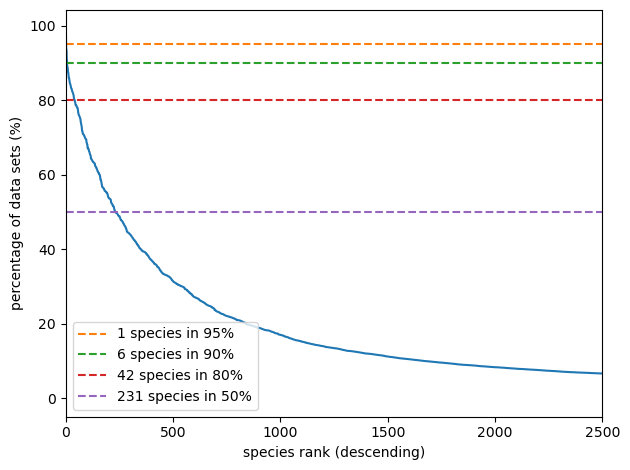

In [21]:
frac = 0
cutoff, total, group_df = filter_combined_df_by_threshold(all_df, condition_df, frac, condition='healthy')

len95 = len(group_df.filter(pl.col("frequency") >= 0.95))
len90 = len(group_df.filter(pl.col("frequency") >= 0.90))
len80 = len(group_df.filter(pl.col("frequency") >= 0.80))
len50 = len(group_df.filter(pl.col("frequency") >= 0.50))


plt.plot(group_df["rank"], group_df["frequency"]*100)
plt.plot([0, len(group_df)], [95, 95], '--', label=f'{len95} species in 95%')
plt.plot([0, len(group_df)], [90, 90], '--', label=f'{len90} species in 90%')
plt.plot([0, len(group_df)], [80, 80], '--', label=f'{len80} species in 80%')
plt.plot([0, len(group_df)], [50, 50], '--', label=f'{len50} species in 50%')

#plt.title("num core species at various thresholds in >= 1GB datasets")
plt.xlabel("species rank (descending)")
plt.ylabel("percentage of data sets (%)")
plt.legend(loc='lower left')
plt.xlim(0, 2500)
plt.tight_layout()

In [26]:
for condition in condition_counts_df['condition']:
    print(condition)
    cutoff, total, group_df = filter_combined_df_by_threshold(all_df, condition_df, frac, condition=condition)
    sub_df = group_df.filter((pl.col("frequency") >= 0.9))
    
    #matches = sub_df.sample(11, seed=42)
    #sub_df
    
    with pl.Config(tbl_rows=-1):
        print(sub_df.select(["rank", "frequency", "species"]))

healthy
shape: (6, 3)
┌──────┬───────────┬─────────────────────────────────┐
│ rank ┆ frequency ┆ species                         │
│ ---  ┆ ---       ┆ ---                             │
│ u32  ┆ f64       ┆ str                             │
╞══════╪═══════════╪═════════════════════════════════╡
│ 0    ┆ 0.992712  ┆ s__Escherichia coli             │
│ 1    ┆ 0.94328   ┆ s__Phocaeicola vulgatus         │
│ 2    ┆ 0.934249  ┆ s__Bacteroides uniformis        │
│ 3    ┆ 0.933879  ┆ s__Parabacteroides distasonis   │
│ 4    ┆ 0.910747  ┆ s__Blautia_A wexlerae           │
│ 5    ┆ 0.906734  ┆ s__Bacteroides thetaiotaomicro… │
└──────┴───────────┴─────────────────────────────────┘
T2D
shape: (22, 3)
┌──────┬───────────┬─────────────────────────────────┐
│ rank ┆ frequency ┆ species                         │
│ ---  ┆ ---       ┆ ---                             │
│ u32  ┆ f64       ┆ str                             │
╞══════╪═══════════╪═════════════════════════════════╡
│ 0    ┆ 0.997863  ┆ s__